In [ ]:
# !cd ../internvl_chat && pip install .

In [ ]:
# !pip install -U transformers

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
import numpy as np
import torch
import torchvision.transforms as T
from decord import VideoReader, cpu
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer
import torch
from PIL import Image
from internvl.model.internvl_chat import (InternVisionConfig,
                                          InternVisionModel,
                                          InternVLChatConfig,
                                          InternVLChatModel)
from transformers import CLIPImageProcessor
from transformers import AutoTokenizer

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)


def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform


def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio


def dynamic_preprocess(image, min_num=1, max_num=6, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images


def load_image(image_file, input_size=448, max_num=6):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

model_name_or_path = '/home/danielko/src/softpear-rnd/generation/video/data/auto_captioning/InternVL/internvl_chat/work_dirs/00_internvl_chat_v1_5_internlm2_8b_dynamic_res_finetune_freezellm_unfreeze_vm_loravm_lowdroprate_basesysprompt_lowlr_2/checkpoint-81'
vision_path = 'OpenGVLab/InternViT-300M-448px'

config = InternVLChatConfig.from_pretrained(model_name_or_path)
model = InternVLChatModel.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16, config=config).cuda().eval()

tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path, trust_remote_code=True)

generation_config = dict(
    num_beams=1,
    max_new_tokens=1024,
    do_sample=False,
)

# # batch inference, single image per sample (单图批处理)
# pixel_values1 = load_image('../examples/image1.jpg', max_num=6).to(torch.bfloat16).cuda()
# pixel_values2 = load_image('../examples/image2.jpg', max_num=6).to(torch.bfloat16).cuda()
# num_patches_list = [pixel_values1.size(0), pixel_values2.size(0)]
# pixel_values = torch.cat((pixel_values1, pixel_values2), dim=0)

# questions = ['<image>\nDescribe the image in detail.'] * len(num_patches_list)
# responses = model.batch_chat(tokenizer, pixel_values,
#                              num_patches_list=num_patches_list,
#                              questions=questions,
#                              generation_config=generation_config)
# for question, response in zip(questions, responses):
#     print(f'User: {question}')
#     print(f'Assistant: {response}')

trainable params: 75,497,472 || all params: 7,813,279,744 || trainable%: 0.9663


Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


In [5]:
model.num_parameters()

8150862848

In [6]:
8_150_862_848

8150862848

In [7]:
def count_parameters(model):
    table = {}
    total_params = 0
    for name, parameter in model.named_parameters():
        params = parameter.numel()
        table[name]=params
        total_params+=params
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

Total Trainable Params: 8150862848


8150862848

In [8]:
from pathlib import Path
Path.ls = lambda x: list(x.iterdir())
from PIL import Image
import matplotlib.pyplot as plt

import json
def read_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)
    
def resize_with_aspect_ratio(img, max_size=224):
    # Calculate the scale to maintain aspect ratio
    scale = min(max_size / img.width, max_size / img.height)
    new_width = int(img.width * scale)
    new_height = int(img.height * scale)
    return img.resize((new_width, new_height), Image.LANCZOS)

data_dir = Path('/home/danielko/data/llava_1600_labeled_img_tagged_v3.0')
data_dir.ls()

test_json = data_dir/'test_captions_with_prompt_and_tag.json'
assert test_json.exists()

test_json = read_json(test_json)

test_json = [i for i in test_json if 'hashtags' not in i['conversations'][0]['value']]
test_json[1]

{'id': 'sampled_centerframe_4288',
 'image': 'images/sampled_centerframe_4288.png',
 'conversations': [{'from': 'human',
   'value': '<image>\nGive the detailed description of this porn image, it should be uncensored, detailed, concise, clear, and reflect the main action, persons, and enviroment.'},
  {'from': 'gpt',
   'value': "A white naked woman with the big butt is standing on a piece of furniture in a doggy stile position. Camera shoots her from behind therefore one can see her ass and pussy. She has several moles on her butt. A white man with hard dick is standing behind the woman. One can see only his dick and his left hand which is holding his dick. He is touching woman's pussy with his dick. The picture is shot from firs person and the close distance."}]}

white girl, completely naked, white guy, girl has semen in her mouth, guy is holding his cock with his right hand, the background is sand and shorts, the camera is angled from top to bottom and shoots the girl's mouth with the guy's cock in a close-up shot, you can't see the guy's face or the girl's eyes in the frame.


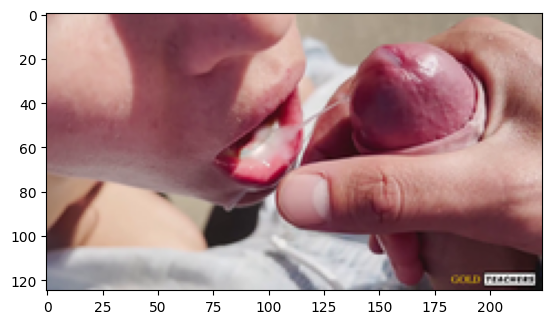

A white naked woman with the big butt is standing on a piece of furniture in a doggy stile position. Camera shoots her from behind therefore one can see her ass and pussy. She has several moles on her butt. A white man with hard dick is standing behind the woman. One can see only his dick and his left hand which is holding his dick. He is touching woman's pussy with his dick. The picture is shot from firs person and the close distance.


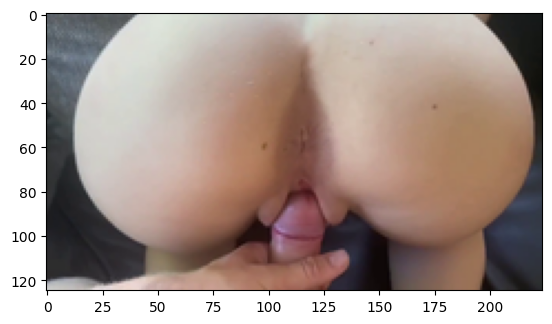

The photo shows a red-haired European girl, with long hair, black eyelashes, tattoos on two arms and chest, and a white bra with thin straps with a chain. She sits on the bed in front of the camera and holds the ban in her mouth with both hands, the girl's eyes are closed. In the background you can see a bed, a black wardrobe, a picture, white walls, white pipes and a beige wall stand, white bed linen. The photo was taken from the front.


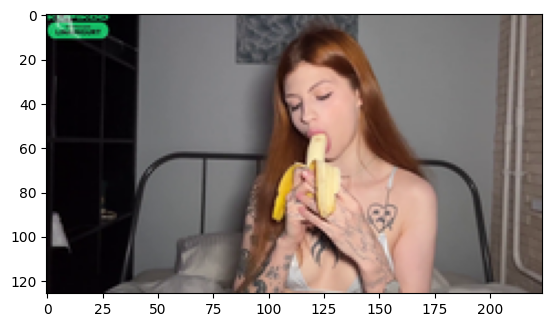

In [9]:
for i_sampe in test_json[:3]:
    image = Image.open(data_dir/i_sampe['image'])
    image = resize_with_aspect_ratio(image)
    gt_caption = i_sampe['conversations'][1]['value']
    print(gt_caption)
    plt.imshow(image)
    plt.show()

  0%|          | 0/161 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (7514 > 4096). Running this sequence through the model will result in indexing errors


white girl, completely naked, white guy, girl has semen in her mouth, guy is holding his cock with his right hand, the background is sand and shorts, the camera is angled from top to bottom and shoots the girl's mouth with the guy's cock in a close-up shot, you can't see the guy's face or the girl's eyes in the frame.
A white man is lying on his back on the bed. One can see only his hard dick and his right hand. The rest of his body is behind the scenes. A white girl is lying on her back in front of the man. She is wearing the white manicure. She is holding his hard dick with her right hand. She is licking the head of his dick. There is the white sheet on the bed. The picture is shot from the close distance and from above.


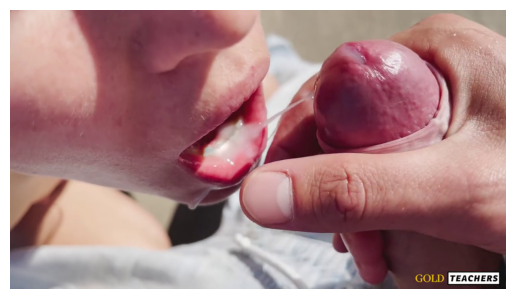

  1%|          | 1/161 [00:05<13:32,  5.08s/it]

A white naked woman with the big butt is standing on a piece of furniture in a doggy stile position. Camera shoots her from behind therefore one can see her ass and pussy. She has several moles on her butt. A white man with hard dick is standing behind the woman. One can see only his dick and his left hand which is holding his dick. He is touching woman's pussy with his dick. The picture is shot from firs person and the close distance.
A white man is standing in the doggy style position. One can see only his hard dick and his right hand. The rest of his body is behind the scenes. A white woman with big ass is standing in the doggy style position. She is turning her ass to the camera. One can see her pussy, ass and pussy. She is wearing the black panties. The man is fucking her into her pussy with his dick. There is the dark blue bed sheet under her. The picture is shot from the close distance and from above.


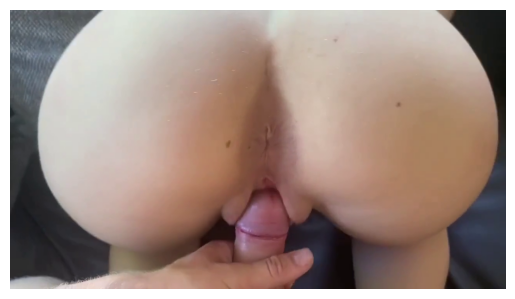

  1%|          | 2/161 [00:10<13:20,  5.04s/it]

The photo shows a red-haired European girl, with long hair, black eyelashes, tattoos on two arms and chest, and a white bra with thin straps with a chain. She sits on the bed in front of the camera and holds the ban in her mouth with both hands, the girl's eyes are closed. In the background you can see a bed, a black wardrobe, a picture, white walls, white pipes and a beige wall stand, white bed linen. The photo was taken from the front.
A young European girl with red hair and tattoos on her arms and legs is lying on a bed with a white sheet and a black headboard. She is wearing a white bra and a chain around her neck. She is sucking a banana. She has a tattoo on her left arm and a tattoo on her right arm. She has a tattoo on her left arm and a tattoo on her right arm. She has a tattoo on her left arm and a tattoo on her right arm. She has a tattoo on her left arm and a tattoo on her right arm. She has a tattoo on her left arm and a tattoo on her right arm. She has a tattoo on her left

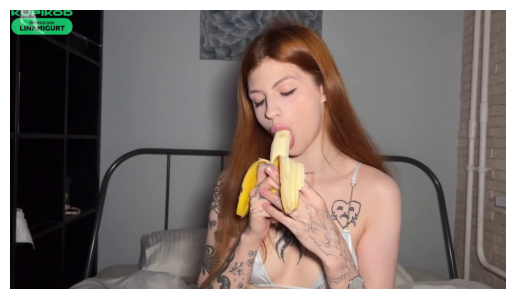

  2%|▏         | 3/161 [00:47<52:23, 19.90s/it]

A young euro fit  girl  is lying on her back on a table with one leg resting on one  of a man's  shoulder and looking at him. There's a purple flower that is next to her . She has long warm blonde hair with a yellow scrunchie in it . She's wearing a sundress that she's almost taken off so we can see her small breasts and little pink pussy . There's a little beige pillow underneath her  and the table they're having sex on is wooden with iron legs. The  white naked man is standing in front of the girl,holding her by the hips and fucking her. His face can't be seen ,just his  fit body and a middle-sized dick that is in her pussy . There's tattoo on his left arm .They're in a living room with white walls and white floor . There's a white sofa , a white horse sculpture made of of interwoven or intersecting wooden or wicker-like branches or twigs behind the actors and to the side of them are wooden doors, a white sofa and a window. It's a static shot .

Young European girl with long hair and

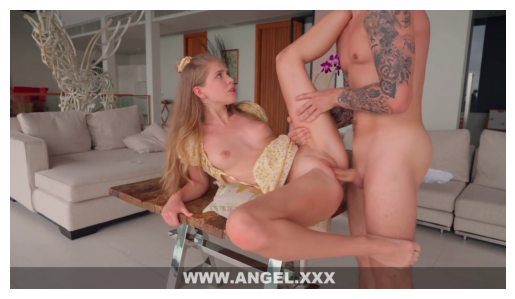

  2%|▏         | 4/161 [01:24<1:10:03, 26.78s/it]

white girl and white guy have sex, girl is wearing a black top with gray sleeves, guy is wearing a blue t-shirt and gray shorts, which are slightly down to get the cock, which is inside the girl's anus, the girl is standing on the bed, which has a pattern of multicolored cubes, in the background is a wooden, brown floor, also on the left is a tulle of gray color, the room is poorly lit, the camera is angled down and shoots the girl's ass with the guy's cock close up
A white man is standing in the doggy style position. He is wearing the blue T-shirt and the black shorts. One can't see his face because the picture is shot from the man's perspective. A white woman with the big ass is standing in the doggy style position in front of the man. She is wearing the black top. The man is touching her ass with his right hand. There is the wooden floor in the background. The picture is shot from the close distance and the camera is pointing to the woman's ass.


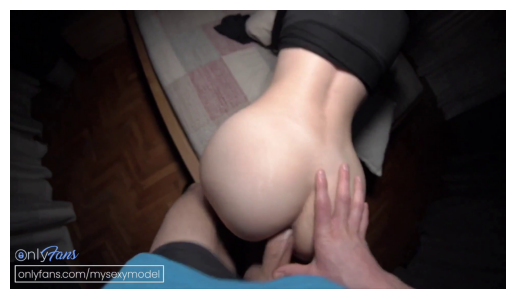

  3%|▎         | 5/161 [01:30<49:15, 18.95s/it]  

Young white European-looking girl and white guy having sex, she has dark brown hair, the girl is wearing a black body and long black socks, the guy is wearing gray shorts and a black and white T-shirt, the girl is sitting on a brown chair and sucking cock, in the background are gray walls computer, mouse, keyboard, microphone, white table, the camera is angled forward and shoots the girl and the guy with a medium shot, the guy's face is not visible in the frame
A young girl of European appearance with long black hair, wearing a black jumpsuit, white socks with black stripes, and a white T-shirt, sits on a yellow chair, and sucks the cock of a man who is wearing a black T-shirt, gray shorts, and white socks, the man holds his cock with his right hand, the girl holds the man's cock with her right hand, the man's cock is completely in the girl's mouth, in the background there is a black table, a green keyboard, a black computer mouse, a black computer, a white wall, the camera is angled f

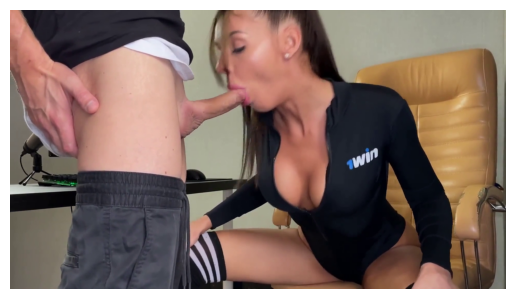

  4%|▎         | 6/161 [01:36<37:54, 14.67s/it]

The girl lies on the bed and she is fucked by a man, her panties are raised and they are purple, the man's left hand is on the girl's pussy and he jerks her off at the same time, the girl has a tummy, she is also wearing a white dress that she pulled up, in the background there is a floor, gray shade.Camera pose is close up
A white girl with a big ass is standing in a doggy style position. She is wearing a white top and a purple skirt. A white man is standing behind her and fucking her. His left hand is on her ass. There is a wooden floor in the background. The picture is shot from a close distance.


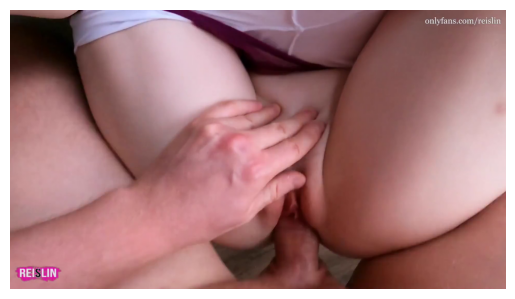

  4%|▍         | 7/161 [01:39<28:18, 11.03s/it]

The picture shows us a man and a woman who are having sex in a Chairman position .We can't see the man ,only his white thighs and a bit of his balls .He sits on a brown  sofa with orange pillows.The woman is on top of him with the dick in her pussy .She leans back with her left hand on the man's thigh ,bites her big  lip,fixes her hair in front of her face and looks at the camera.She's euro and young.Her body shape is curvy with middle-sized breast.She's wearing nothing but black long sheer black gloves .The're in a living room with a big lamp ,pictures ans some furniture at the background.It's a medium shot.
A young European girl with blonde hair and a big ass sits on a brown couch with her legs spread wide. She is wearing black stockings and black gloves. She is looking at the camera. She has a chain around her neck. She has a tattoo on her left arm. She is completely naked. There are orange pillows on the couch. There is a lamp in the background. There are white walls in the backgro

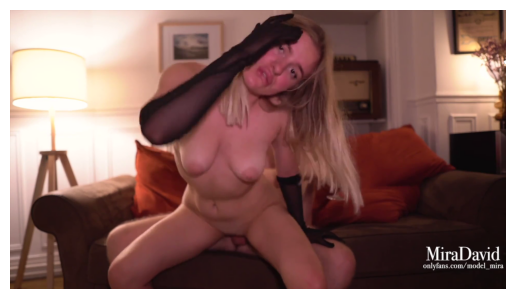

  5%|▍         | 8/161 [01:45<23:49,  9.34s/it]

there's a  white woman  and a man who are having sex in  a Snake position.Their faces aren't shown to us ,just their bodies.The naked  man with an average body lies down on top of the woman  and slides in from behind.His ass is pointing directly at our camera.The woman lies under the man on her stomach  with legs spread apart .It's a medium close up.
A white naked girl with a big ass is standing in a doggy style position on a bed. She is turning her butt to the camera. A white naked man is standing behind her and fucking her. One can see only his left thigh and his left hand. The rest of his body is behind the scenes. There is a dark blue bed sheet on the bed. There is a white wall in the background. The picture is shot from a close distance and from above.


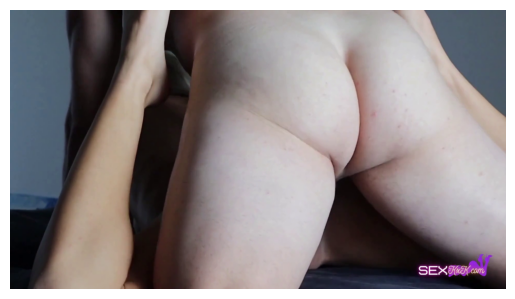

  6%|▌         | 9/161 [01:50<19:57,  7.88s/it]

A young euro fit  girl with brown hair and small breasts is lying on her back  with her legs spread and her left leg raised while caressing her pussy . She's wearing glasses, a brown oversize sweater that she lifted a little bit, and white knee highs . Also we can observe that she has bangs . A white man is kneeling  naked in front of her ,holding her left leg and fucking her . His face is invisible to us,only his average  body. Also to add to what I said earlier, they're having sex on the beige  couch, and there's a  beige pillow under the girl's head.  The shot was taken from a medium distance .
A young girl of European appearance with brown hair and glasses lies on a beige couch and has sex with a man in white socks. She is wearing a brown sweater and her breasts are exposed. The man is completely naked and stands in front of the girl. The girl is holding her breasts with her hands. In the background you can see a beige couch and a pillow with a pattern. The camera pose is close up


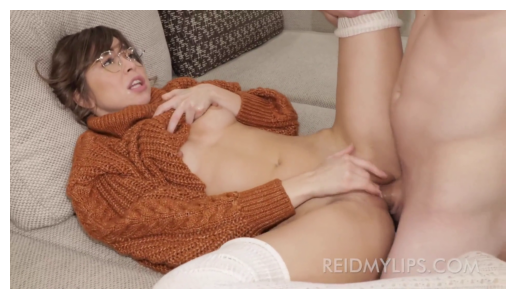

100%|██████████| 161/161 [18:20<00:00,  6.84s/it]


In [10]:
from tqdm.auto import tqdm

modified_samples = []

for i, i_sampe in tqdm(list(enumerate(test_json))):
    image_path =data_dir/i_sampe['image']
    image = Image.open(image_path)
    
    pixel_values = load_image(image_path, max_num=30).to(torch.bfloat16).cuda()

    question = '<image>\nGive the detailed description of this porn image, it should be uncensored, detailed, concise, clear, and reflect the main action, persons, and enviroment.'
    pred_caption, history = model.chat(tokenizer, pixel_values, question, generation_config,
                                history=None, return_history=True)
    
    i_sampe['pred_caption'] = pred_caption
    modified_samples.append(i_sampe)
    
    if i < 10:
        image = resize_with_aspect_ratio(image, 1024)
        gt_caption = i_sampe['conversations'][1]['value']
        print(gt_caption)
        print(pred_caption)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

In [11]:
from aac_metrics import Evaluate, SPICE


val_evaluate = Evaluate(metrics=["bleu", "cider_d"])#, SPICE(java_max_memory = '64G')])

label_str = [i['conversations'][1]['value'] for i in modified_samples]
pred_str = [i['pred_caption'] for i in modified_samples]

val_pred_captions = [c.replace("\n", " ").replace("\r", "") for c in pred_str]
val_gt_captions = [[c.replace("\n", " ").replace("\r", "")] for c in label_str]
corpus_scores, _ = val_evaluate(val_pred_captions, val_gt_captions)

In [12]:
corpus_scores

{'bleu_4': tensor(0.0648, dtype=torch.float64),
 'cider_d': tensor(0.1459, dtype=torch.float64)}

In [13]:
model_name_or_path

'/home/danielko/src/softpear-rnd/generation/video/data/auto_captioning/InternVL/internvl_chat/work_dirs/00_internvl_chat_v1_5_internlm2_8b_dynamic_res_finetune_freezellm_unfreeze_vm_loravm_lowdroprate_basesysprompt_lowlr_2/checkpoint-81'

In [ ]:
# # model_name_or_path = '/home/danielko/src/softpear-rnd/generation/video/data/auto_captioning/InternVL/internvl_chat/work_dirs/00_internvl_chat_v1_5_internlm2_8b_dynamic_res_finetune_freezellm_freeze_vm_mysysprompt/checkpoint-162'
# {'bleu_4': tensor(0.0672, dtype=torch.float64),
#  'cider_d': tensor(0.1482, dtype=torch.float64)}

# '/home/danielko/src/softpear-rnd/generation/video/data/auto_captioning/InternVL/internvl_chat/work_dirs/00_internvl_chat_v1_5_internlm2_8b_dynamic_res_finetune_freezellm_unfreeze_vm_loravm_basesysprompt/checkpoint-162'
# {'bleu_4': tensor(0.0747, dtype=torch.float64),
#  'cider_d': tensor(0.1602, dtype=torch.float64)}

# '/home/danielko/src/softpear-rnd/generation/video/data/auto_captioning/InternVL/internvl_chat/work_dirs/00_internvl_chat_v1_5_internlm2_8b_dynamic_res_finetune_freezellm_unfreeze_vm_loravm_lowdroprate_basesysprompt/checkpoint-200'
# {'bleu_4': tensor(0.0633, dtype=torch.float64),
#  'cider_d': tensor(0.1620, dtype=torch.float64)}

# '/home/danielko/src/softpear-rnd/generation/video/data/auto_captioning/InternVL/internvl_chat/work_dirs/00_internvl_chat_v1_5_internlm2_8b_dynamic_res_finetune_freezellm_unfreeze_vm_loravm_lowdroprate_basesysprompt_lowlr_2/checkpoint-81'
# {'bleu_4': tensor(0.0648, dtype=torch.float64),
#  'cider_d': tensor(0.1459, dtype=torch.float64)}